# Librerie e funzioni d'utilità

In [2]:
import os
import wfdb as wf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.colors
import pandas as pd
import warnings
import random
import shutil
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
blu_fiordaliso = "#6495ED"
lilla = "#c8a2c8"
nero = "#000000"
gradient = ["#ffffff", "#dcc4dc","#c8a2c8", "#a787ad", "#93779c", "#735d82", "#6c4675"]
my_cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", gradient)

In [4]:
matrix = np.array([[149030, 34],[7442, 12]])
norm = matplotlib.colors.Normalize(matrix.min(), matrix.max())
boundaries = [value for value in matrix.flatten().tolist()]
list.sort(boundaries)
colors = [[norm(boundaries[0]), "#dcc4dc"], 
          [norm(boundaries[1]), "#c8a2c8"], 
          [norm(boundaries[2]), "#93779c"], 
          [norm(boundaries[3]), "#6c4675"]]
my_cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

In [5]:
def remove_and_make_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        os.mkdir(path)
    else:
        os.mkdir(path)

In [6]:
heartbeats_datasets = "heartbeats_dataset.json"
base_heartbeats_path = ".\\heartbeats\\"
plot_path = ".\\plot\\"

In [7]:
# remove_and_make_dir(base_heartbeats_path)
# remove_and_make_dir(plot_path)

In [8]:
directory_dataset = ".\\mitdb\\"

In [9]:
# create directory "mitdb" and download dataset
if not os.path.exists(directory_dataset):
    os.mkdir(directory_dataset)
    wfdb.dl_database("mitdb", directory_dataset)

# wf.io.show_ann_classes()
# wf.io.show_ann_labels()

In [10]:
wf.io.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

# Distribuzione etichette

In [74]:
# extract filename from directory
list_of_file = list(set([x.rsplit('.', 1)[0] for x in os.listdir(directory_dataset)]))
list_of_file.sort()

In [75]:
# key = filename, value = [record(tuple), annotation(array)]
dataset = {}

for filename in list_of_file:
    file = os.path.join(directory_dataset, filename)
    
    # read the file
    record = wf.rdsamp(file)
    annotation = wf.rdann(file, 'atr')
    dataset[filename] = [record, annotation]
    
    # info about the data
    print("File:", file)
    print("Sampling frequency:", record[1].get("fs"))
    print("Data shape:", record[0].shape)
    print("Annotations:", len(annotation.num))
    print("\n")

File: .\mitdb\100
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2274


File: .\mitdb\101
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 1874


File: .\mitdb\102
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2192


File: .\mitdb\103
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2091


File: .\mitdb\104
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2311


File: .\mitdb\105
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2691


File: .\mitdb\106
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2098


File: .\mitdb\107
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2140


File: .\mitdb\108
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 1824


File: .\mitdb\109
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2535


File: .\mitdb\111
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 2133


File: .\mitdb\112
Sampling frequency: 360
Data shape: 

In [76]:
# distribution of annotation
labels = {}
for record in dataset.values():
    annotypes = np.array(record[1].symbol)
    for label in annotypes:
        if label in labels.keys():
            labels[label] += 1
        else:
            labels[label] = 1
labels = dict(sorted(labels.items(), key=lambda item: item[1], reverse=True))

In [77]:
# plot bar chart esteso
def bar_plot_ex(keys, values, title, path, dim):
    plt.figure(figsize=dim) 
    plt.yscale("log")
    plt.grid(color=nero, linestyle='-', linewidth=0.5, axis="y")
    plt.title(title)
    p = plt.bar(keys, values, width=1, color=lilla, edgecolor=nero, linewidth=0.5, align='center')
    plt.xticks(rotation = 90)
    plt.savefig(plot_path + path, bbox_inches='tight', transparent=True)
    plt.show()

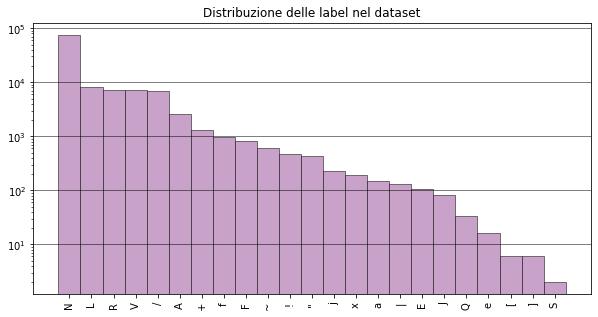

In [78]:
keys = labels.keys()
values = [item for item in labels.values()]
title = "Distribuzione delle label nel dataset"
file_name = "".join(title.lower()).replace(" ", "_")
dim = (10,5)
bar_plot_ex(keys, values, title, file_name, dim)

In [80]:
tmp = {}
for key, record in dataset.items():
    annotypes = np.array(record[1].symbol)
    tmp[key] = dict.fromkeys(labels.keys(), 0)
    for label in annotypes:
        tmp[key][label] = tmp[key][label] + 1

df = pd.DataFrame.from_dict(tmp)
df = df.replace(0, np.nan)
df = df.T

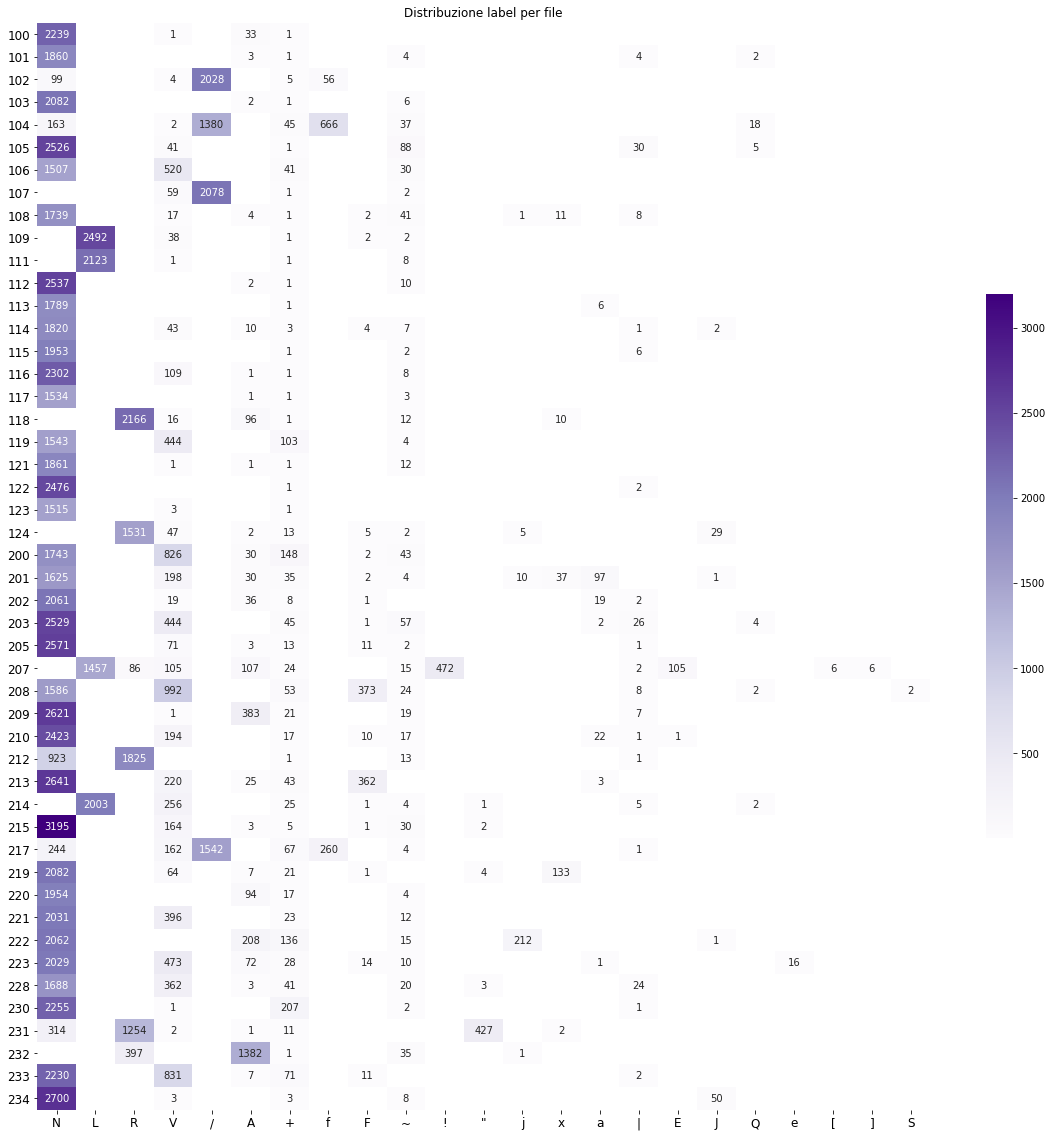

In [81]:
fig, ax = plt.subplots(figsize=(20,20)) 
title = "Distribuzione label per file"
file_name = "".join(title.lower()).replace(" ", "_")
ax.set_title(title)
ax.set_xlabel("Label")
ax.set_ylabel("File")
heatmap = sns.heatmap(df, ax=ax, annot=True, fmt=".0f", cmap="Purples", cbar_kws={"shrink": .5})
a = heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation = 0, fontsize = 12)
b = heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation = 0, fontsize = 12)
fig.savefig(plot_path + file_name, bbox_inches='tight', transparent=True)

# Plot ECG

In [84]:
def plot_ecg(channel, sample_start, sample_size, record, annotation):
    # get data and annotations for the samples selected below
    sample_end = sample_start + sample_size
    signal = record[0][sample_start:sample_end, channel]

    # plot the heart beats
    # time scale is number of readings divided by sampling frequency
    times = (np.arange(sample_size, dtype = 'float') + sample_start) / record[1].get('fs')
    plt.figure(figsize=(10,5))
    plt.plot(times, signal)

    # extract annotations
    where = np.logical_and(annotation.sample >= sample_start, annotation.sample < sample_end)
    annots = annotation.sample[where] - sample_start
    annotypes = np.array(annotation.symbol)
    annotypes = annotypes[where]

    # plot the annotations
    annotimes = times[annots]
    plt.plot(annotimes, np.ones_like(annotimes) * signal.max() * 1.4, 'ro')

    # annotation codes
    for idx, annot in enumerate(annots):
        plt.annotate(annotypes[idx], xy = (times[annot], signal.max() * 1.1))

    plt.xlim([sample_start / record[1].get('fs'), (sample_end / record[1].get('fs'))])
    plt.xlabel('Offset')
    plt.ylabel(record[1].get('sig_name')[channel])
    plt.savefig(plot_path + "ecg", bbox_inches='tight', transparent=True)
    plt.show()

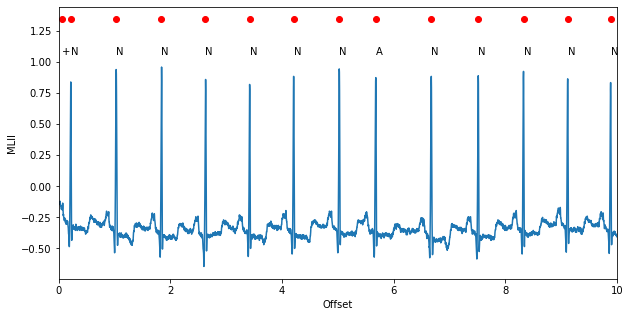

In [87]:
# there are 2 channels -> MLII wave = 0
channel = 0             

# start of the sample in the file
sample_start = 0        

# number of readings (360 per second)
sample_size = 3600      

record = dataset["100"][0]
annotation = dataset["100"][1]

plot_ecg(channel, sample_start, sample_size, record, annotation)

# Creazione dataset di heartbeat

In [88]:
def get_heartbeat(channel, sample_start, sample_size, record, annotation):

    sample_end = sample_start + sample_size
    signal = record[0][sample_start:sample_end, channel]

    times = (np.arange(sample_size, dtype = 'float') + sample_start) / record[1].get('fs')

    where = np.logical_and(annotation.sample >= sample_start, annotation.sample < sample_end)
    annots = annotation.sample[where] - sample_start
    annotypes = np.array(annotation.symbol)
    annotypes = annotypes[where]

    annotimes = times[annots]
    
    return (signal, times, annotypes, annotimes, annots)    

In [93]:
def plot_heartbeat(signal, times, annotypes, annotimes, annots, title):

    plt.figure(figsize=(5,3))
    plt.plot(times, signal)
    plt.plot(annotimes, np.ones_like(annotimes) * signal.max() * 1.4, 'ro')

    for idx, annot in enumerate(annots):
        plt.annotate(annotypes[idx], xy = (times[annot], signal.max() * 1.1))
        
    title = "Heartbeat " + title
    plt.title(title)
    
    plt.xlabel("Time offset")
    plt.ylabel("mV")
    
    title = title.replace("/", "AAA")
    file_name = "".join(title.lower()).replace(" ", "_")
    plt.savefig(plot_path + file_name, bbox_inches='tight', transparent=True)

    plt.show()

In [90]:
channel = 0             
heartbeat_size = 300 
ds = []
for key in dataset.keys():
    record = dataset[key][0]
    annotation = dataset[key][1]
    for pos_of_annotation in annotation.sample:
        heartbeat_start = 0 if (pos_of_annotation - 149) < 0 else pos_of_annotation - 149
        ds.append(get_heartbeat(channel, heartbeat_start, heartbeat_size, record, annotation))

In [91]:
df = pd.DataFrame(ds, columns=["signal", "times", "annotypes", "annotimes", "annots"])
# plot_heartbeat(df["signal"][0], df["times"][0],df["annotypes"][0], df["annotimes"][0], df["annots"][0])
print("Numero record:", len(df))
display(df.head())

Numero record: 112647


,signal,times,annotypes,annotimes,annots
0,"[-0.145, -0.145, -0.145, -0.145, -0.145, -0.14...","[0.0, 0.002777777777777778, 0.0055555555555555...","[+, N]","[0.05, 0.21388888888888888]","[18, 77]"
1,"[-0.145, -0.145, -0.145, -0.145, -0.145, -0.14...","[0.0, 0.002777777777777778, 0.0055555555555555...","[+, N]","[0.05, 0.21388888888888888]","[18, 77]"
2,"[-0.265, -0.27, -0.265, -0.26, -0.275, -0.28, ...","[0.6138888888888889, 0.6166666666666667, 0.619...",[N],[1.0277777777777777],[149]
3,"[-0.305, -0.315, -0.315, -0.31, -0.295, -0.29,...","[1.425, 1.4277777777777778, 1.4305555555555556...",[N],[1.8388888888888888],[149]
4,"[-0.325, -0.305, -0.31, -0.295, -0.31, -0.325,...","[2.213888888888889, 2.216666666666667, 2.21944...",[N],[2.6277777777777778],[149]


In [92]:
# delete heartbeat with more one annotation and with len of signal less 300
df1 = df[df['annotypes'].str.len() == 1]
df1 = df1[df1['signal'].str.len() == 300]
print("Numero record:", len(df1))
display(df1.head())

Numero record: 104222


,signal,times,annotypes,annotimes,annots
2,"[-0.265, -0.27, -0.265, -0.26, -0.275, -0.28, ...","[0.6138888888888889, 0.6166666666666667, 0.619...",[N],[1.0277777777777777],[149]
3,"[-0.305, -0.315, -0.315, -0.31, -0.295, -0.29,...","[1.425, 1.4277777777777778, 1.4305555555555556...",[N],[1.8388888888888888],[149]
4,"[-0.325, -0.305, -0.31, -0.295, -0.31, -0.325,...","[2.213888888888889, 2.216666666666667, 2.21944...",[N],[2.6277777777777778],[149]
5,"[-0.285, -0.3, -0.305, -0.3, -0.295, -0.3, -0....","[3.0055555555555555, 3.0083333333333333, 3.011...",[N],[3.4194444444444443],[149]
6,"[-0.3, -0.285, -0.28, -0.29, -0.295, -0.305, -...","[3.7944444444444443, 3.797222222222222, 3.8, 3...",[N],[4.208333333333333],[149]


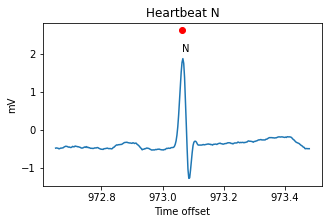

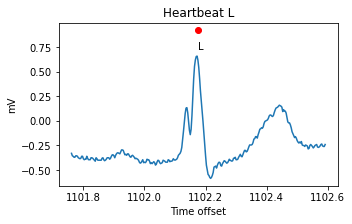

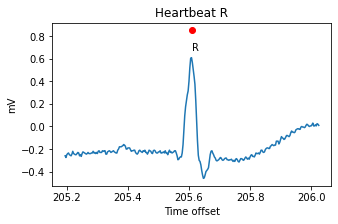

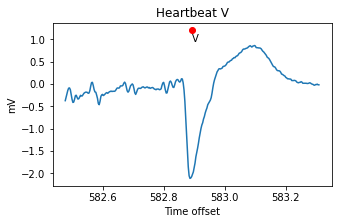

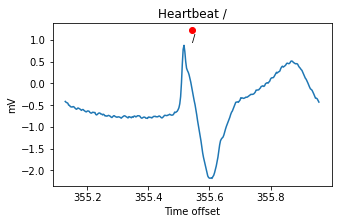

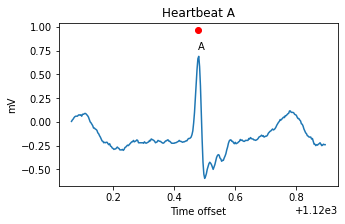

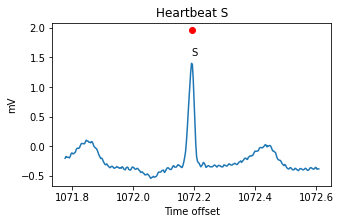

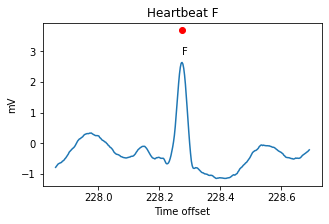

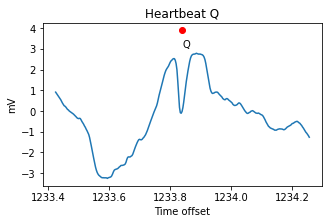

In [99]:
random.seed(100)
list_of_annotypes = ["N", "L", "R", "V", "/", "A", "S", "F", "Q"]
for annot in list_of_annotypes:
    condition = df1["annotypes"] == annot
    rows = df1[condition].index.tolist()
    row = random.sample(rows, 1)
    record = df1.loc[row]
    r = record.to_dict(orient="list")
    plot_heartbeat(r["signal"][0], r["times"][0], r["annotypes"][0], r["annotimes"][0], r["annots"][0], annot)

In [ ]:
list_of_annotypes = ["N", "L", "R", "V", "/", "A"]
df2 = df1[["signal", "annotypes"]]
df2["annotypes"] = df2["annotypes"].apply(lambda v: v[0])
df2 = df2[df2["annotypes"].isin(list_of_annotypes)]
print("Numero record:", len(df2))
display(df2.head())

In [ ]:
df2.to_json(base_heartbeats_path + heartbeats_datasets, orient="index")

# Addestramento modelli

In [11]:
import tensorflow as tf
from d2l import tensorflow as d2l
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D, LSTM, GlobalAveragePooling1D, Dense, Reshape
from keras.callbacks import EarlyStopping

In [12]:
list_of_annotypes = ["N", "L", "R", "V", "/", "A"]

In [13]:
annots_to_onehot = {
    "N": [1., 0., 0., 0., 0., 0.],
    "L": [0., 1., 0., 0., 0., 0.],
    "R": [0., 0., 1., 0., 0., 0.],
    "V": [0., 0., 0., 1., 0., 0.],
    "/": [0., 0., 0., 0., 1., 0.],
    "A": [0., 0., 0., 0., 0., 1.]
}

In [14]:
onehot_to_annots = {
    (1., 0., 0., 0., 0., 0.): "N",
    (0., 1., 0., 0., 0., 0.): "L",
    (0., 0., 1., 0., 0., 0.): "R",
    (0., 0., 0., 1., 0., 0.): "V",
    (0., 0., 0., 0., 1., 0.): "/",
    (0., 0., 0., 0., 0., 1.): "A"
}

In [15]:
def plot_confusion_matrix(y_test, y_prediction, name):
    test_class = []
    for x in y_prediction:
        tmp = np.zeros(len(x))
        tmp[np.argmax(x)] = 1
        test_class.append(tmp)

    test = [onehot_to_annots[tuple(x)] for x in y_test]
    pred = [onehot_to_annots[tuple(x)] for x in test_class]

    matrix = {}
    for i in list_of_annotypes:
        matrix[i] = {}
        for j in list_of_annotypes:
            matrix[i][j] = 0
    for t, p in zip(test, pred):
        matrix[t][p] += 1
    df = pd.DataFrame(matrix)
    
    fig, ax = plt.subplots(figsize=(7,7)) 
    title = "Matrice di confusione " + name
    file_name = "".join(title.lower()).replace(" ", "_")
    ax.set_title(title)
    heatmap = sns.heatmap(df, ax=ax, annot=True, fmt=".0f", linewidths=2, linecolor="#FFFFFF", cmap="Purples", cbar_kws={"shrink": .5}, square=True)
    heatmap.set(xlabel='True class', ylabel='Predicted class')
    a = heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation = 0, fontsize = 12)
    b = heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation = 0, fontsize = 12)
    fig.savefig(plot_path + file_name, bbox_inches='tight', transparent=True)

In [16]:
def plot_history(h):
    # summarize history for accuracy
    plt.plot(h['accuracy'], color="red", linewidth="2", marker='o')
    plt.plot(h['val_accuracy'], color="blue", linewidth="2", marker='o')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(h['loss'], color="red", linewidth="2", marker='o')
    plt.plot(h['val_loss'], color="blue", linewidth="2", marker='o')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### Pre-processing dataset

In [56]:
df = pd.read_json(base_heartbeats_path + heartbeats_datasets, orient="index")
df.head()

,signal,annotypes
2,"[-0.265, -0.27, -0.265, -0.26, -0.275, -0.28, ...",N
3,"[-0.305, -0.315, -0.315, -0.31, -0.295, -0.29,...",N
4,"[-0.325, -0.305, -0.31, -0.295, -0.31, -0.325,...",N
5,"[-0.28500000000000003, -0.30000000000000004, -...",N
6,"[-0.30000000000000004, -0.28500000000000003, -...",N


In [57]:
df["annotypes"].value_counts()

N    71611
L     7943
R     7206
/     6957
V     5411
A     2140
Name: annotypes, dtype: int64

In [58]:
condition = df["annotypes"] == "N"
rows = df[condition].index.tolist()

random.seed(0)
n_rows_to_delete = 60_000
rows_to_delete = random.sample(rows, n_rows_to_delete)

df1 = df.drop(rows_to_delete)

In [59]:
df1["annotypes"].value_counts()

N    11611
L     7943
R     7206
/     6957
V     5411
A     2140
Name: annotypes, dtype: int64

In [60]:
x = df1['signal'].tolist()
y = [annots_to_onehot[x] for x in df1['annotypes'].tolist()]

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
x_val = np.asarray(x_val)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_val)

### Modello 1: paper1

In [32]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="valid", input_shape=[300, 1]),
    keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="valid"),
    keras.layers.MaxPooling1D(pool_size=2, strides=2),
    keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding="valid"),
    keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding="valid"),
    keras.layers.MaxPooling1D(pool_size=2, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(6, activation=tf.nn.softmax)
])

# model.summary()

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val))
# print(history.history)

Epoch 1/5
207/207 [==============================] - 51s 244ms/step - loss: 0.0762 - accuracy: 0.9185 - val_loss: 0.0315 - val_accuracy: 0.9697
Epoch 2/5
207/207 [==============================] - 51s 245ms/step - loss: 0.0262 - accuracy: 0.9771 - val_loss: 0.0242 - val_accuracy: 0.9786
Epoch 3/5
207/207 [==============================] - 49s 238ms/step - loss: 0.0163 - accuracy: 0.9866 - val_loss: 0.0231 - val_accuracy: 0.9796
Epoch 4/5
207/207 [==============================] - 51s 246ms/step - loss: 0.0175 - accuracy: 0.9854 - val_loss: 0.0177 - val_accuracy: 0.9844
Epoch 5/5
207/207 [==============================] - 49s 239ms/step - loss: 0.0142 - accuracy: 0.9874 - val_loss: 0.0128 - val_accuracy: 0.9880


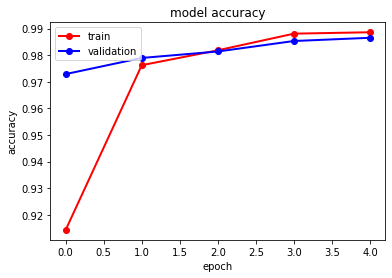

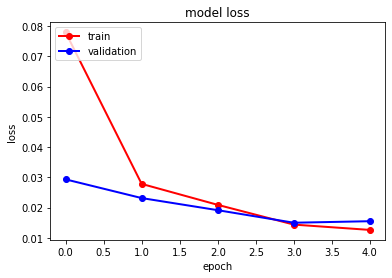

In [24]:
plot_history(history.history)

In [25]:
test_error_rate = model.evaluate(x_test, y_test, batch_size=128)

65/65 [==============================] - 5s 79ms/step - loss: 0.0191 - accuracy: 0.9844


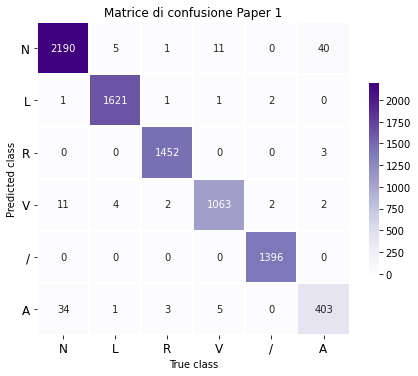

In [26]:
y_prediction = model.predict(x_test)
plot_confusion_matrix(y_test, y_prediction, "Paper 1")

### Modello 2: paper2

In [27]:
input_tot = Input(shape=(300, 1), name ="Input_tot")

# Pipeline 1
branch1_1 = keras.layers.Conv1D(filters=8, kernel_size=4, activation='relu', name ="branch1_1")(input_tot)
branch1_2 = keras.layers.MaxPooling1D(pool_size=2, strides=2, name ="branch1_2")(branch1_1)
branch1_3 = keras.layers.Conv1D(filters=24, kernel_size=6, activation='relu', name ="branch1_3")(branch1_2)
branch1_4 = keras.layers.MaxPooling1D(pool_size=2, strides=2, name ="branch1_4")(branch1_3)

# Pipeline 2
branch2_1 = keras.layers.Conv1D(filters=8, kernel_size=6, activation='relu', name ="branch2_1")(input_tot)
branch2_2 = keras.layers.MaxPooling1D(pool_size=2, strides=2, name ="branch2_2")(branch2_1)
branch2_3 = keras.layers.Conv1D(filters=24, kernel_size=8, activation='relu', name ="branch2_3")(branch2_2)
branch2_4 = keras.layers.MaxPooling1D(pool_size=2, strides=2, name ="branch2_4")(branch2_3)

# Pipeline 3
branch3_1 = keras.layers.Conv1D(filters=8, kernel_size=8, activation='relu', name ="branch3_1")(input_tot)
branch3_2 = keras.layers.MaxPooling1D(pool_size=2, strides=2, name ="branch3_2")(branch3_1)
branch3_3 = keras.layers.Conv1D(filters=24, kernel_size=10, activation='relu', name ="branch3_3")(branch3_2)
branch3_4 = keras.layers.MaxPooling1D(pool_size=2, strides=2, name ="branch3_4")(branch3_3)

# Merge pipelines
branch_concatenate = concatenate([branch1_4,branch2_4,branch3_4], axis=1, name="concatenated_layer")

flatten = keras.layers.Flatten()(branch_concatenate)

dense1 = Dense(256, activation = "relu", name = "dense1")(flatten)
dense2 = Dense(32, activation = "relu", name = "dense2")(dense1)
output_layer = Dense(6, activation = "softmax", name = "output_layer")(dense2)

model = Model(inputs=[input_tot], outputs=[output_layer])

# model.summary()

In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val))
# print(history.history)

Epoch 1/5
207/207 [==============================] - 16s 71ms/step - loss: 0.1362 - accuracy: 0.8612 - val_loss: 0.0490 - val_accuracy: 0.9568
Epoch 2/5
207/207 [==============================] - 14s 67ms/step - loss: 0.0393 - accuracy: 0.9668 - val_loss: 0.0282 - val_accuracy: 0.9749
Epoch 3/5
207/207 [==============================] - 14s 67ms/step - loss: 0.0260 - accuracy: 0.9791 - val_loss: 0.0209 - val_accuracy: 0.9836
Epoch 4/5
207/207 [==============================] - 14s 67ms/step - loss: 0.0190 - accuracy: 0.9850 - val_loss: 0.0177 - val_accuracy: 0.9850
Epoch 5/5
207/207 [==============================] - 14s 66ms/step - loss: 0.0163 - accuracy: 0.9871 - val_loss: 0.0150 - val_accuracy: 0.9876


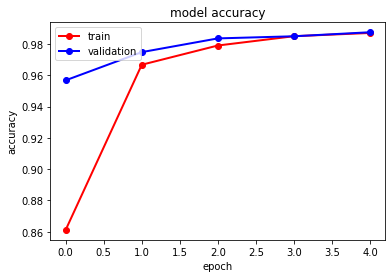

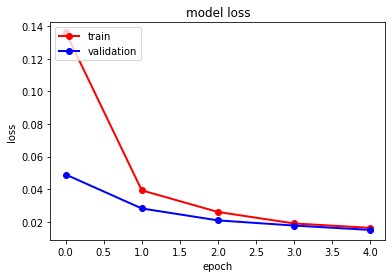

In [29]:
plot_history(history.history)

In [30]:
test_error_rate = model.evaluate(x_test, y_test, batch_size=128)

65/65 [==============================] - 1s 18ms/step - loss: 0.0164 - accuracy: 0.9856


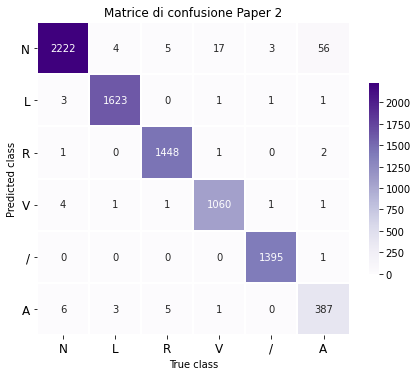

In [31]:
y_prediction = model.predict(x_test)
plot_confusion_matrix(y_test, y_prediction, "Paper 2")

### Modello 3: WaveNet

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[300, 1]))

for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate))
    
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(6, activation=tf.nn.softmax))

# model.summary()

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val))
# print(history.history)

Epoch 1/5
207/207 [==============================] - 39s 182ms/step - loss: 0.1594 - accuracy: 0.8141 - val_loss: 0.0873 - val_accuracy: 0.9250
Epoch 2/5
207/207 [==============================] - 44s 211ms/step - loss: 0.0662 - accuracy: 0.9384 - val_loss: 0.0509 - val_accuracy: 0.9497
Epoch 3/5
207/207 [==============================] - 42s 202ms/step - loss: 0.0479 - accuracy: 0.9552 - val_loss: 0.0414 - val_accuracy: 0.9599
Epoch 4/5
207/207 [==============================] - 36s 176ms/step - loss: 0.0390 - accuracy: 0.9633 - val_loss: 0.0357 - val_accuracy: 0.9662
Epoch 5/5
207/207 [==============================] - 55s 266ms/step - loss: 0.0331 - accuracy: 0.9694 - val_loss: 0.0324 - val_accuracy: 0.9677


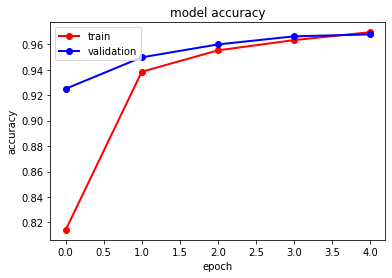

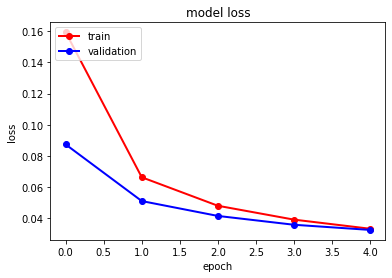

In [34]:
plot_history(history.history)

In [35]:
test_error_rate = model.evaluate(x_test, y_test, batch_size=128)

65/65 [==============================] - 5s 79ms/step - loss: 0.0354 - accuracy: 0.9677


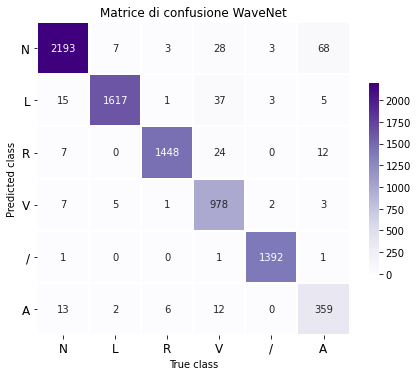

In [36]:
y_prediction = model.predict(x_test)
plot_confusion_matrix(y_test, y_prediction, "WaveNet")

### Modello 4: LSTM 1

In [37]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_lstm_model((300, 1), 6)
# model.summary()

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val))
# print(history.history)

Epoch 1/5
207/207 [==============================] - 687s 3s/step - loss: 0.3595 - accuracy: 0.4825 - val_loss: 0.2460 - val_accuracy: 0.7145
Epoch 2/5
207/207 [==============================] - 804s 4s/step - loss: 0.2050 - accuracy: 0.7662 - val_loss: 0.1707 - val_accuracy: 0.8199
Epoch 3/5
207/207 [==============================] - 744s 4s/step - loss: 0.1712 - accuracy: 0.8188 - val_loss: 0.1752 - val_accuracy: 0.8164
Epoch 4/5
207/207 [==============================] - 636s 3s/step - loss: 0.1279 - accuracy: 0.8790 - val_loss: 0.1082 - val_accuracy: 0.9038
Epoch 5/5
207/207 [==============================] - 749s 4s/step - loss: 0.1242 - accuracy: 0.8807 - val_loss: 0.0984 - val_accuracy: 0.9106


In [ ]:
plot_history(history.history)

In [39]:
test_error_rate = model.evaluate(x_test, y_test, batch_size=128)

65/65 [==============================] - 42s 651ms/step - loss: 0.1029 - accuracy: 0.9033


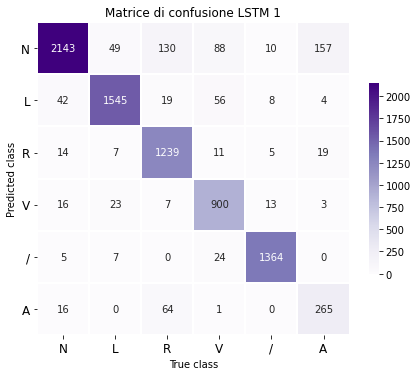

In [40]:
y_prediction = model.predict(x_test)
plot_confusion_matrix(y_test, y_prediction, "LSTM 1")

### Modello 5: LSTM 2

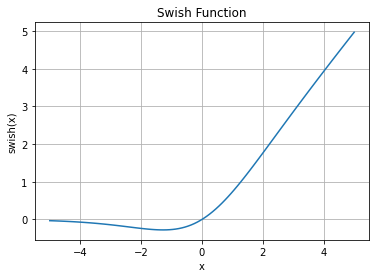

In [41]:
x = np.linspace(-5, 5, 100)

def swish(x):
    return x * K.sigmoid(x)

y = swish(x)

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('swish(x)')
plt.title('Swish Function')
plt.grid()
plt.show()

In [42]:
def create_model(input_shape, n_classes):
    inputs = Input(shape=input_shape)

    x = Conv1D(32, kernel_size=3, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv1D(128, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)

    x = LSTM(128, return_sequences=True, go_backwards=False, dropout=0.5)(x)
    x = LSTM(128, return_sequences=False, go_backwards=True, dropout=0.5)(x)

    x = Reshape((-1, 128))(x)

    x = GlobalAveragePooling1D()(x)

    outputs = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

model = create_model((300, 1), 6)
# model.summary()

In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val))
# print(history.history)

Epoch 1/5
207/207 [==============================] - 386s 2s/step - loss: 0.3421 - accuracy: 0.4891 - val_loss: 0.6001 - val_accuracy: 0.2768
Epoch 2/5
207/207 [==============================] - 364s 2s/step - loss: 0.1565 - accuracy: 0.8167 - val_loss: 0.5702 - val_accuracy: 0.4124
Epoch 3/5
207/207 [==============================] - 364s 2s/step - loss: 0.0891 - accuracy: 0.9112 - val_loss: 0.1553 - val_accuracy: 0.8198
Epoch 4/5
207/207 [==============================] - 364s 2s/step - loss: 0.0708 - accuracy: 0.9302 - val_loss: 0.2833 - val_accuracy: 0.6765
Epoch 5/5
207/207 [==============================] - 365s 2s/step - loss: 0.0595 - accuracy: 0.9432 - val_loss: 0.0526 - val_accuracy: 0.9482


In [ ]:
plot_history(history.history)

In [44]:
test_error_rate = model.evaluate(x_test, y_test, batch_size=128)

65/65 [==============================] - 23s 351ms/step - loss: 0.0521 - accuracy: 0.9477


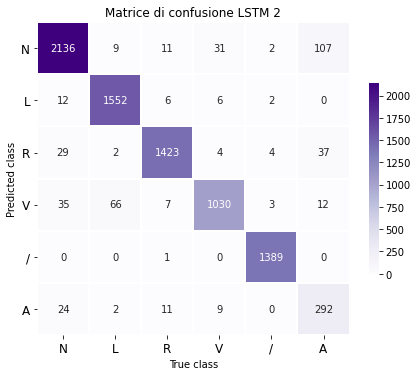

In [45]:
y_prediction = model.predict(x_test)
plot_confusion_matrix(y_test, y_prediction, "LSTM 2")

### Modello 6: DBN

In [69]:
# Definizione dell'architettura della DBN
visible = Input(shape=(300,))
hidden1 = Dense(256, activation='relu')(visible)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden2)
hidden3 = Dense(64, activation='relu')(dropout2)
dropout3 = Dropout(0.2)(hidden3)
output = Dense(6, activation='softmax')(dropout3)

model = Model(inputs=visible, outputs=output)
# model.summary()

In [70]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val))
# print(history.history)

Epoch 1/5
207/207 [==============================] - 2s 6ms/step - loss: 0.1835 - accuracy: 0.7978 - val_loss: 0.0673 - val_accuracy: 0.9452
Epoch 2/5
207/207 [==============================] - 1s 4ms/step - loss: 0.0693 - accuracy: 0.9415 - val_loss: 0.0427 - val_accuracy: 0.9611
Epoch 3/5
207/207 [==============================] - 1s 4ms/step - loss: 0.0499 - accuracy: 0.9576 - val_loss: 0.0351 - val_accuracy: 0.9677
Epoch 4/5
207/207 [==============================] - 1s 4ms/step - loss: 0.0389 - accuracy: 0.9676 - val_loss: 0.0270 - val_accuracy: 0.9735
Epoch 5/5
207/207 [==============================] - 1s 4ms/step - loss: 0.0333 - accuracy: 0.9718 - val_loss: 0.0277 - val_accuracy: 0.9768


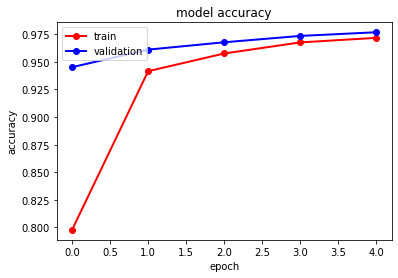

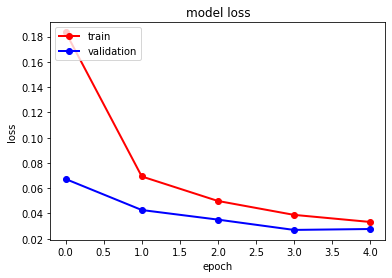

In [71]:
plot_history(history.history)

In [72]:
test_error_rate = model.evaluate(x_test, y_test, batch_size=128)

65/65 [==============================] - 0s 3ms/step - loss: 0.0279 - accuracy: 0.9759


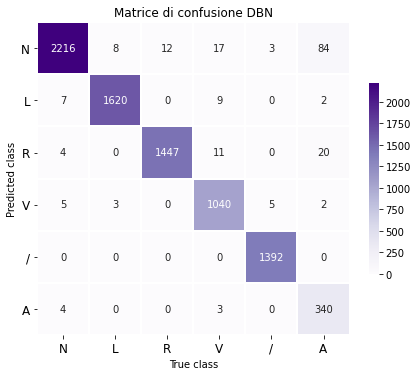

In [73]:
y_prediction = model.predict(x_test)
plot_confusion_matrix(y_test, y_prediction, "DBN")

### Modello 7: Autoencoder

In [54]:
input_data = Input(shape=(300, 1))
encoded = Dense(100, activation='relu')(input_data)
encoded = Dense(50, activation='relu')(encoded)
decoded = Dense(100, activation='relu')(encoded)
decoded = Dense(300, activation='sigmoid')(decoded)
autoencoder = Model(input_data, decoded)

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, validation_data=(x_val, x_val))

In [ ]:
# Utilizzare l'encoder per ottenere la rappresentazione codificata dei dati di input
encoder = Model(input_data, encoded)
encoded_input = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)

encoded_dim = 50
num_classes = 6

# Utilizzare la rappresentazione codificata come input per la classificazione
input_data = Input(shape=(encoded_dim,))
classification = Dense(100, activation='relu')(input_data)
classification = Dense(50, activation='relu')(classification)
classification = Dense(num_classes, activation='softmax')(classification)
model = Model(input_data, classification)
# model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val))
# print(history.history)

In [ ]:
plot_history(history.history)

In [ ]:
test_error_rate = model.evaluate(x_test, y_test, batch_size=128)

In [ ]:
y_prediction = model.predict(x_test)
plot_confusion_matrix(y_test, y_prediction, "Autoencoder")